# Konfidensintervall

In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

In [3]:
n = 1000
heights = np.random.normal(loc=172, scale=7, size=n)

heights[:5] = [145, 198, 205, 150, 190]

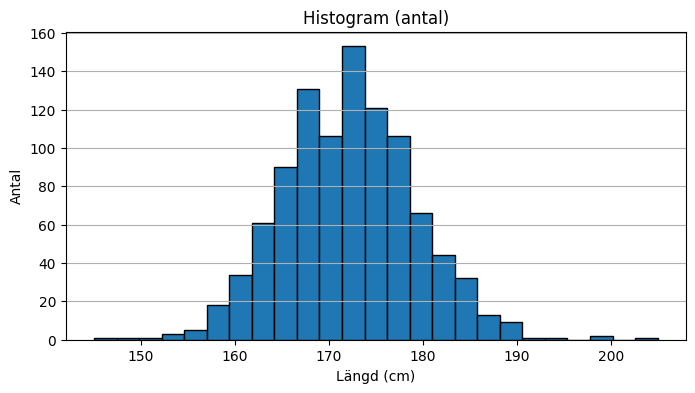

In [4]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(heights, bins=25, edgecolor="black")
ax.set_title("Histogram (antal)")
ax.set_xlabel("Längd (cm)")
ax.set_ylabel("Antal")
ax.grid(True, axis="y")


In [5]:
mean_x = np.mean(heights)
median_x = np.median(heights)
s = np.std(heights, ddof=1)

mean_x, median_x, s

(np.float64(172.1472592866549),
 np.float64(172.17710428564422),
 np.float64(7.080690527822804))

In [6]:
def normal_pdf(x, m, s):
    x = np.asarray(x, dtype=float)
    if s <= 0 or not np.isfinite(s):
        raise ValueError("s måste vara ett positivt, ändligt tal")
    
    norm = 1.0 / (s * np.sqrt(2.0 * np.pi))
    z = (x - m) / s
    y = norm * np.exp(-0.5 * z**2)
    return y




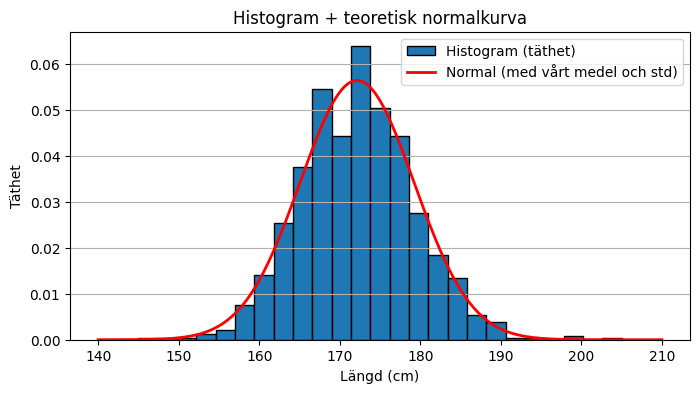

In [7]:
x_support = np.linspace(heights.min()-5, heights.max()+5, 400)

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(heights, bins=25, edgecolor="black", density=True, label="Histogram (täthet)")

m = np.mean(heights)
s = np.std(heights, ddof=1)

ax.plot(x_support, normal_pdf(x_support, m, s), color="red", lw=2, label="Normal (med vårt medel och std)")


ax.set_title("Histogram + teoretisk normalkurva")
ax.set_xlabel("Längd (cm)")
ax.set_ylabel("Täthet")
ax.grid(True, axis="y")
ax.legend()


In [8]:
np.random.seed(123)
population = np.random.normal(loc=50, scale=10, size=500_000)
true_mean = float(np.mean(population))
true_mean

50.010098782870855

In [9]:
n = 40
x = np.random.choice(population, size=n, replace=True)

mean_x = float(np.mean(x))
s = float(np.std(x, ddof=1))
se = s / np.sqrt(n)
mean_x, s, n, se

(48.70134238441775, 9.712622290279342, 40, np.float64(1.53570042451019))

In [10]:
from math import sqrt

def ci_mean_normal(x, confidence=0.95):
    """
    95%-CI för medel med normal-approximation:
    medel ± 1.96 * (s / sqrt(n))
    """
    x = np.asarray(x, dtype=float)
    mean_x = float(np.mean(x))
    s = float(np.std(x, ddof=1))
    n = len(x)

    z_critical = 1.96
    half_width = z_critical * s / sqrt(n)
    lo, hi = mean_x - half_width, mean_x + half_width
    return lo, hi, mean_x, s, n

lo, hi, mean_x, s, n = ci_mean_normal(x)
(lo, hi), mean_x, s, n, true_mean

((45.69136955237778, 51.71131521645772),
 48.70134238441775,
 9.712622290279342,
 40,
 50.010098782870855)

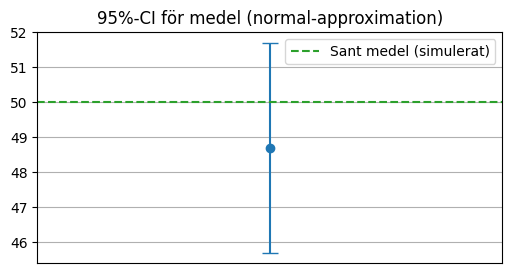

In [ ]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.errorbar([0], [mean_x], yerr=[[mean_x - lo], [hi - mean_x]], fmt="o", capsize=6)
ax.axhline(true_mean, color="tab:green", linestyle="--", label="Sant medel (simulerat)")
ax.set_xticks([])
ax.grid(True, axis="y")
ax.legend()
ax.set_title("95%-CI för medel (normal-approximation)")

In [12]:
def ci_mean_bootstrap(x, B=5000, confidence=0.95):
    x = np.asarray(x, dtype=float)
    n = len(x)
    boot_means = np.empty(B)
    for b in range(B):
        boot_sample = np.random.choice(x, size=n, replace=True)
        boot_means[b] = np.mean(boot_sample)

    alpha = (1 - confidence) / 2 #2.5: procentilen och 97.5:e procentilen
    lo, hi = np.percentile(boot_means, [100*alpha, 100*(1 - alpha)])
    return float(lo), float(hi), float(np.mean(x))

blo, bhi, bmean = ci_mean_bootstrap(x, B=3000)
(blo, bhi), bmean, true_mean

((45.75007815150547, 51.66060691343894), 48.70134238441775, 50.010098782870855)

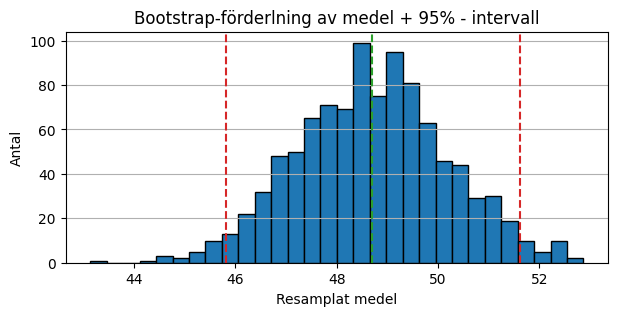

In [13]:
fig, ax = plt.subplots(figsize=(7,3))
bm = np.array([np.mean(np.random.choice(x, size=len(x), replace=True)) for _ in range(1000)])

ax.hist(bm, bins=30, edgecolor="black")
ax.axvline(np.mean(x), color="tab:green", linestyle="--", label="Stickprovsmedel")
ax.axvline(np.percentile(bm, 2.5), color="tab:red", linestyle="--", label="2.5%")
ax.axvline(np.percentile(bm, 97.5), color="tab:red", linestyle="--", label="97.5%")
ax.set_title("Bootstrap-förderlning av medel + 95% - intervall")
ax.set_xlabel("Resamplat medel")
ax.set_ylabel("Antal")
ax.grid(True, axis="y")

In [14]:
print("Normal-CI:", (lo, hi))
print("Bootstrap-CI:", (blo, bhi))
print("Stickprovsmedel:", mean_x, "     Sant medel:", true_mean)

Normal-CI: (45.69136955237778, 51.71131521645772)
Bootstrap-CI: (45.75007815150547, 51.66060691343894)
Stickprovsmedel: 48.70134238441775      Sant medel: 50.010098782870855


In [15]:
def covers_true_mean(method = "normal", n=40, trials=200):
    hits = 0
    for _ in range(trials):
        sample = np.random.choice(population, size=n, replace=True)
        if method == "normal":
            lo, hi, *_ = ci_mean_normal(sample)
        else:
            lo, hi, *_ = ci_mean_bootstrap(sample, B=1500)
        hits += (lo <= true_mean <= hi)
    return hits / trials


cov_normal = covers_true_mean("normal", n=40, trials=200)
cov_boot = covers_true_mean("bootstrap", n=40, trials=200)

cov_normal, cov_boot

(0.955, 0.955)